In [2]:
import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline
import six

from perturbseq import *

from collections import Counter

In [3]:
import scanpy as sc

rpe1e150 = sc.read('/data/norman/southark/rpe1e150_standardized/20240227_RPE1_E150_all_genes.h5ad')

/tmp/ipykernel_67562/1061443416.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  singlet_representation = singlets.groupby('feature_call').number_of_cells.count()[singlets.groupby('feature_call').number_of_cells.count() > 0]


Dataset 1 statistics:
count   156.0000
mean      0.0064
std       0.0047
min       0.0003
25%       0.0036
50%       0.0050
75%       0.0072
max       0.0280
Name: number_of_cells, dtype: float64

Dataset 2 statistics:
count   156.0000
mean      0.0064
std       0.0044
min       0.0004
25%       0.0036
50%       0.0050
75%       0.0079
max       0.0251
dtype: float64


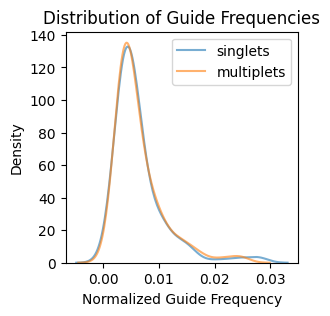

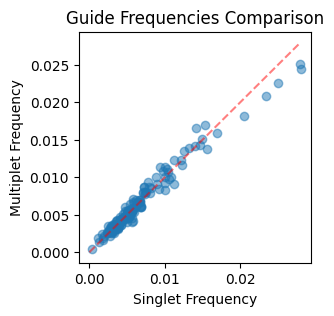


Correlation between datasets: 0.984

Difference statistics for common guides:
count   156.0000
mean     -0.0000
std       0.0009
min      -0.0036
25%      -0.0004
50%       0.0001
75%       0.0004
max       0.0025
Name: Difference, dtype: float64


In [4]:
singlets = rpe1e150.obs.query('number_of_cells == 1').copy()

multiplets = rpe1e150.obs.query('number_of_cells >= 4').copy()

singlet_representation = singlets.groupby('feature_call').number_of_cells.count()[singlets.groupby('feature_call').number_of_cells.count() > 0]

#get guide representation in multiplets
# Split into a list of all guide combinations
all_guide_combinations = multiplets['feature_call'].str.cat(sep='|').split('|')

# Use collections.Counter for efficient counting
guide_counts = Counter(all_guide_combinations)

guide_counts_series = pd.Series(guide_counts)
guide_counts_series.sort_values(ascending=False, inplace=True)

guide_counts1 = singlet_representation
guide_counts2 = guide_counts_series

# Assuming you have guide_counts1 and guide_counts2
# First normalize each to proportions/frequencies
norm_counts1 = guide_counts1 / guide_counts1.sum()
norm_counts2 = guide_counts2 / guide_counts2.sum()

# Basic statistical comparison
print("Dataset 1 statistics:")
print(norm_counts1.describe())
print("\nDataset 2 statistics:")
print(norm_counts2.describe())

# Create visualization of distributions
plt.figure(figsize=(3, 3))

# Plot density distributions
sns.kdeplot(data=norm_counts1, label='singlets', alpha=0.6)
sns.kdeplot(data=norm_counts2, label='multiplets', alpha=0.6)
plt.xlabel('Normalized Guide Frequency')
plt.ylabel('Density')
plt.title('Distribution of Guide Frequencies')
plt.legend()
plt.show()

## Convert common_guides set to list for indexing
common_guides = list(set(norm_counts1.index) & set(norm_counts2.index))

comparison_df = pd.DataFrame({
    'Dataset1': norm_counts1[common_guides],
    'Dataset2': norm_counts2[common_guides]
})

plt.figure(figsize=(3, 3))
plt.scatter(comparison_df['Dataset1'], comparison_df['Dataset2'], alpha=0.5)
plt.plot([0, max(norm_counts1.max(), norm_counts2.max())], 
         [0, max(norm_counts1.max(), norm_counts2.max())], 
         'r--', alpha=0.5)  # diagonal line for reference
plt.xlabel('Singlet Frequency')
plt.ylabel('Multiplet Frequency')
plt.title('Guide Frequencies Comparison')
plt.show()

# Calculate correlation
correlation = comparison_df['Dataset1'].corr(comparison_df['Dataset2'])
print(f"\nCorrelation between datasets: {correlation:.3f}")

# Calculate some basic difference metrics
print("\nDifference statistics for common guides:")
comparison_df['Difference'] = comparison_df['Dataset2'] - comparison_df['Dataset1']
print(comparison_df['Difference'].describe())

/tmp/ipykernel_67562/4207804881.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  singlet_representation = singlets.groupby(feature_col)[num_cell_col].count()[
/tmp/ipykernel_67562/4207804881.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  singlets.groupby(feature_col)[num_cell_col].count() > 0



=== RPE1_E150 Analysis ===

Singlets statistics:
count   156.0000
mean      0.0064
std       0.0047
min       0.0003
25%       0.0036
50%       0.0050
75%       0.0072
max       0.0280
Name: number_of_cells, dtype: float64

Multiplets statistics:
count   156.0000
mean      0.0064
std       0.0045
min       0.0004
25%       0.0035
50%       0.0049
75%       0.0076
max       0.0254
dtype: float64


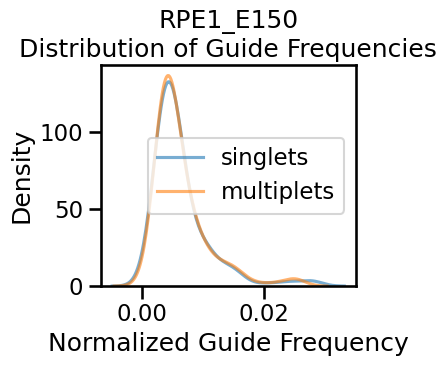

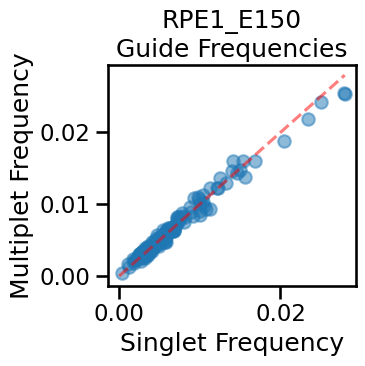

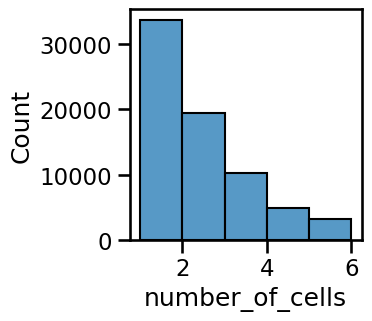


Correlation between singlets and multiplets: 0.990

Difference statistics for common guides:
count   156.0000
mean     -0.0000
std       0.0007
min      -0.0027
25%      -0.0002
50%       0.0000
75%       0.0004
max       0.0019
Name: Difference, dtype: float64


In [57]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_guide_frequencies(adata, dataset_name, num_cell_col = 'number_of_cells', feature_col = 'feature_call'):
    """
    Analyze guide frequencies in singlets vs multiplets for a given dataset.
    
    Parameters:
    -----------
    adata : AnnData
        Dataset containing 'number_of_cells' and 'feature_call' in obs
    dataset_name : str
        Name of the dataset for labeling outputs
        
    Returns:
    --------
    dict
        Dictionary containing correlation and comparison dataframe
    """
    # Split into singlets and multiplets

    
    singlets = adata.obs.query(f'{num_cell_col} == 1').copy()
    multiplets = adata.obs.query(f'{num_cell_col}  >= 2').copy()
    
    # Calculate guide representation in singlets
    singlet_representation = singlets.groupby(feature_col)[num_cell_col].count()[
        singlets.groupby(feature_col)[num_cell_col].count() > 0
    ]
    
    # Calculate guide representation in multiplets
    all_guide_combinations = multiplets[feature_col].str.cat(sep='|').split('|')
    guide_counts = Counter(all_guide_combinations)
    guide_counts_series = pd.Series(guide_counts)
    guide_counts_series.sort_values(ascending=False, inplace=True)
    
    # Normalize counts
    norm_counts1 = singlet_representation / singlet_representation.sum()
    norm_counts2 = guide_counts_series / guide_counts_series.sum()
    
    # Print statistics
    print(f"\n=== {dataset_name} Analysis ===")
    print("\nSinglets statistics:")
    print(norm_counts1.describe())
    print("\nMultiplets statistics:")
    print(norm_counts2.describe())
    
    # Plot density distributions
    plt.figure(figsize=(4, 4))
    sns.kdeplot(data=norm_counts1, label='singlets', alpha=0.6)
    sns.kdeplot(data=norm_counts2, label='multiplets', alpha=0.6)
    plt.xlabel('Normalized Guide Frequency')
    plt.ylabel('Density')
    plt.title(f'{dataset_name}\nDistribution of Guide Frequencies')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_density.pdf')
    plt.show()
    
    # Prepare comparison data
    common_guides = list(set(norm_counts1.index) & set(norm_counts2.index))
    comparison_df = pd.DataFrame({
        'Singlets': norm_counts1[common_guides],
        'Multiplets': norm_counts2[common_guides]
    })
    
    # Create scatter plot
    plt.figure(figsize=(4, 4))
    plt.scatter(comparison_df['Singlets'], comparison_df['Multiplets'], alpha=0.5)
    plt.plot([0, max(norm_counts1.max(), norm_counts2.max())],
             [0, max(norm_counts1.max(), norm_counts2.max())],
             'r--', alpha=0.5)
    plt.xlabel('Singlet Frequency')
    plt.ylabel('Multiplet Frequency')
    plt.title(f'{dataset_name}\nGuide Frequencies')
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_scatter.pdf')
    plt.show()

    #plot hist of # of cells per droplet
    plt.figure(figsize= (3,3))

    sns.histplot(adata.obs[num_cell_col], binwidth = 1)
    plt.savefig(f'{dataset_name}_cell_loading_distribution.pdf')
    plt.show()
    
    # Calculate correlation and differences
    correlation = comparison_df['Singlets'].corr(comparison_df['Multiplets'])
    print(f"\nCorrelation between singlets and multiplets: {correlation:.3f}")
    
    comparison_df['Difference'] = comparison_df['Multiplets'] - comparison_df['Singlets']
    print("\nDifference statistics for common guides:")
    print(comparison_df['Difference'].describe())
    
    return {
        'correlation': correlation,
        'comparison_df': comparison_df
    }

# Example usage:
results_rpe1e150 = analyze_guide_frequencies(rpe1e150, "RPE1_E150")
# results_dataset2 = analyze_guide_frequencies(dataset2, "Dataset2")
# results_dataset3 = analyze_guide_frequencies(dataset3, "Dataset3")

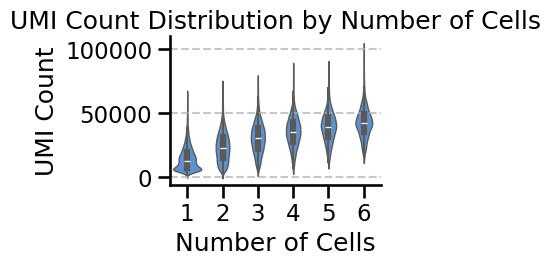

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your data is in a dataframe with columns 'number_of_cells' and 'UMI_count'
plt.figure(figsize=(4, 3))
sns.set_context('talk')

# Create violin plot with improved styling
sns.violinplot(x='number_of_cells', y='UMI_count', 
               data=rpe1e150.obs,
               inner='box',  # Shows box plot inside violin
               color='#4A90E2',  # Main violin color
               linewidth=1,
               #saturation=0.7
              )  # Slightly desaturate the color

# Customize the plot
plt.title('UMI Count Distribution by Number of Cells')
plt.xlabel('Number of Cells')
plt.ylabel('UMI Count')

# Customize grid and style
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set background style
#plt.style.use('white')

# Adjust layout
plt.tight_layout()

# If you want to save it
plt.savefig('violin_plot.png', dpi=300, bbox_inches='tight')

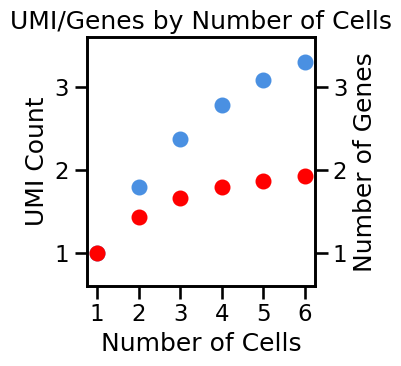

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate means if needed
mean_by_cells = rpe1e150.obs.groupby('number_of_cells')['UMI_count'].median()

#normalize by singlets
mean_by_cells = mean_by_cells/mean_by_cells[1]


# If your data is in sparse format, use:
n_genes_per_cell = rpe1e150.X.astype(bool).sum(axis=1).A1
rpe1e150.obs['n_genes'] = n_genes_per_cell

ngenes_by_cells =rpe1e150.obs.groupby('number_of_cells')['n_genes'].median()
#normalize by singlets
ngenes_by_cells = ngenes_by_cells/ngenes_by_cells[1]

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(4.5, 4))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot UMI counts on left axis
line1 = ax1.scatter(mean_by_cells.index, mean_by_cells.values, 
                    color='#4A90E2',
                    s=100,
                    label='UMI Counts')

# Plot number of genes on right axis
line2 = ax2.scatter(ngenes_by_cells.index, ngenes_by_cells.values, 
                    color='red',
                    s=100,
                    label='Number of Genes')


# Set the same range for both axes
ax1.set_ylim(0.6, 3.6)
ax2.set_ylim(0.6, 3.6)


# Customize left axis
ax1.set_xlabel('Number of Cells')
ax1.set_ylabel('UMI Count')
ax1.tick_params(axis='y')

# Customize right axis
ax2.set_ylabel('Number of Genes')
ax2.tick_params(axis='y')

# Set x-axis ticks
ax1.set_xticks(mean_by_cells.index)

# Add title
plt.title('UMI/Genes by Number of Cells')


plt.tight_layout()
plt.show()

In [8]:
# If your data is in sparse format, use:
n_genes_per_cell = rpe1e150.X.astype(bool).sum(axis=1).A1

# Add it to your adata.obs
rpe1e150.obs['n_genes'] = n_genes_per_cell

In [32]:
rpe1e150.ob

AAACCCAAGAAGGCTC-1    7710
AAACCCAAGAGGGCGA-1    5698
AAACCCAAGCAGTAAT-1    2191
AAACCCAAGCCATTTG-1    3167
AAACCCAAGGTATAGT-1    5118
                      ... 
TTTGTTGTCTACGGGC-2    4482
TTTGTTGTCTAGAACC-2    2449
TTTGTTGTCTCAGAAC-2    3735
TTTGTTGTCTGTAAGC-2    4874
TTTGTTGTCTTCGGAA-2    2819
Name: n_genes, Length: 71566, dtype: int64

In [9]:
#fold median umi count
#fold median genes detected per cell

In [10]:
fibro_a = sc.read('/data/norman/southark/tfs_standardized/240116_fibroblast_CRISPRa_scanpy_from_cellranger_aggr_singlets_and_multiplets_5umi_guide_thresh.h5ad')

In [11]:
fibro_a = fibro_a[fibro_a.obs.num_cells <= 6].copy()

In [12]:
fibro_a.obs.sort_values('num_cells')

,dataset,UMI_count,guide_identity,guide_umi_count,thresholded_features,thresholded_guide_umi,num_cells
AAAGAACCAGACTGCC-1,aggr_ALL,7329.0000,ZNF652_GGAGCCGGCGGTTATCTGGG,110.0000,ZNF652_GGAGCCGGCGGTTATCTGGG,110,1.0000
AAAGAACCAGAGCTAG-1,aggr_ALL,7242.0000,ZNF701_GCGGGGCCTGATCGAGGTAG,576.0000,ZNF701_GCGGGGCCTGATCGAGGTAG,576,1.0000
TTTGTTGCAAAGCAAT-16,aggr_ALL,7061.0000,ZNF189_GCAATCGGATACAATCCCAG,142.0000,ZNF189_GCAATCGGATACAATCCCAG,142,1.0000
TTTGTTGCAACACGTT-16,aggr_ALL,4797.0000,MLLT10_GGCCCACCCCCAGCACACCT,173.0000,MLLT10_GGCCCACCCCCAGCACACCT,173,1.0000
TTTGTTGCAACTGCTA-16,aggr_ALL,4861.0000,MTERF1_GTCGCCTGGGCAGATGTCCG,248.0000,MTERF1_GTCGCCTGGGCAGATGTCCG,248,1.0000
...,...,...,...,...,...,...,...
TTCCAATGTGGTTCTA-13,aggr_ALL,9051.0000,FOXN2_GGGCCGAGCCCCCTTCCTCG,554.0000,BLZF1_GCCCTCCACGCTGTCGCCTG|FOXN2_GGGCCGAGCCCCC...,21|554|46|13|448|472,6.0000
TAGACCATCAATCGGT-9,aggr_ALL,14100.0000,NOCT_GGAGCTGGAGGGGAATCCGC,482.0000,BID_GCCTTCGGCCCCCCACGCCC|FOSL2_GGCTCGGCGGGGACA...,279|188|482|114|261|16,6.0000
GAGTGAGTCGGCTTCT-15,aggr_ALL,10441.0000,SLC22A1_GGCCCGGGAGCGAGTCAGTG,24.0000,EPAS1_GTGCGGCCGCGCGTCCCCAT|MAFA_GCCCAGCTGTCAAT...,12|23|20|24|10|22,6.0000
TAGCACATCAGAATAG-9,aggr_ALL,6874.0000,CNBP_GCCCCGCGCCGCGCTCTAGT,658.0000,CNBP_GCCCCGCGCCGCGCTCTAGT|FOXB2_GCGCCAGTCGGCAA...,658|104|147|47|24|79,6.0000


/tmp/ipykernel_67562/4207804881.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  singlet_representation = singlets.groupby(feature_col)[num_cell_col].count()[
/tmp/ipykernel_67562/4207804881.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  singlets.groupby(feature_col)[num_cell_col].count() > 0



=== fibro_a Analysis ===

Singlets statistics:
count   10927.0000
mean        0.0001
std         0.0001
min         0.0000
25%         0.0000
50%         0.0001
75%         0.0001
max         0.0020
Name: num_cells, dtype: float64

Multiplets statistics:
count   10978.0000
mean        0.0001
std         0.0001
min         0.0000
25%         0.0000
50%         0.0001
75%         0.0001
max         0.0022
dtype: float64


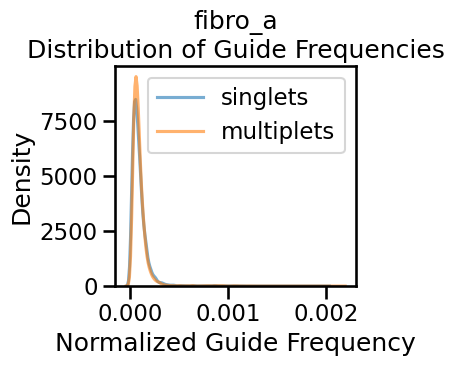

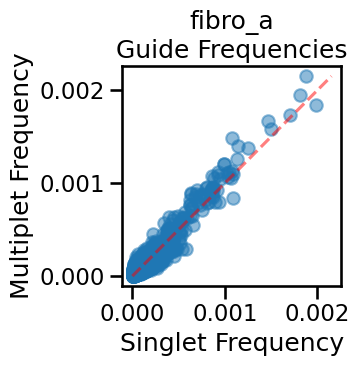

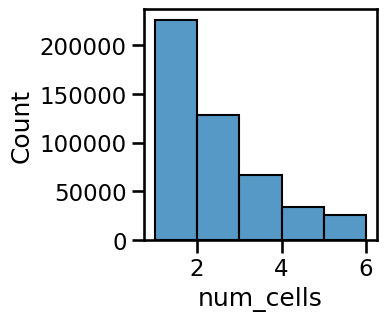


Correlation between singlets and multiplets: 0.925

Difference statistics for common guides:
count   10927.0000
mean       -0.0000
std         0.0000
min        -0.0003
25%        -0.0000
50%         0.0000
75%         0.0000
max         0.0004
Name: Difference, dtype: float64


In [13]:
results_fibro_a = analyze_guide_frequencies(fibro_a, "fibro_a", num_cell_col='num_cells', feature_col='thresholded_features')

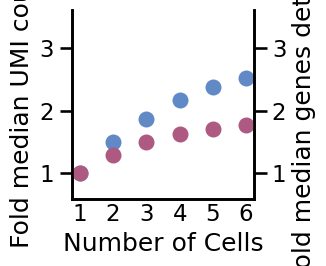

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate means if needed
mean_by_cells = fibro_a.obs.groupby('num_cells')['UMI_count'].median()

#normalize by singlets
mean_by_cells = mean_by_cells/mean_by_cells[1]


# If your data is in sparse format, use:
n_genes_per_cell = fibro_a.X.astype(bool).sum(axis=1).A1
fibro_a.obs['n_genes'] = n_genes_per_cell

ngenes_by_cells =fibro_a.obs.groupby('num_cells')['n_genes'].median()
#normalize by singlets
ngenes_by_cells = ngenes_by_cells/ngenes_by_cells[1]


# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(3.6, 3))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


# Plot UMI counts on left axis
line1 = ax1.scatter(mean_by_cells.index, mean_by_cells.values, 
                    color='#6089C6',
                    s=100,
                    label='UMI Counts')

# Plot number of genes on right axis
line2 = ax2.scatter(ngenes_by_cells.index, ngenes_by_cells.values, 
                    color='#AE5982',
                    s=100,
                    label='Number of Genes')


# Set the same range for both axes
ax1.set_ylim(0.6, 3.6)
ax2.set_ylim(0.6, 3.6)


# Customize left axis
ax1.set_xlabel('Number of Cells')
ax1.set_ylabel('Fold median UMI count')
ax1.tick_params(axis='y')

# Customize right axis
ax2.set_ylabel('Fold median genes detected')
#ax2.tick_params(axis='y')

# Set x-axis ticks
ax1.set_xticks(mean_by_cells.index)
ax1.tick_params(axis='x', length=0)  # This removes the tick marks but keeps labels

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)


plt.tight_layout()
plt.savefig('fibro_a_umi_count_saturation.pdf')

In [22]:
#normalize by singlets
mean_by_cells/mean_by_cells[1]

num_cells
1.0000   1.0000
2.0000   1.4990
3.0000   1.8734
4.0000   2.1607
5.0000   2.3820
6.0000   2.5235
Name: UMI_count, dtype: float32

/tmp/ipykernel_67562/4207804881.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  singlet_representation = singlets.groupby(feature_col)[num_cell_col].count()[
/tmp/ipykernel_67562/4207804881.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  singlets.groupby(feature_col)[num_cell_col].count() > 0



=== rpe1_a Analysis ===

Singlets statistics:
count   10937.0000
mean        0.0001
std         0.0001
min         0.0000
25%         0.0000
50%         0.0001
75%         0.0001
max         0.0016
Name: num_cells, dtype: float64

Multiplets statistics:
count   10978.0000
mean        0.0001
std         0.0001
min         0.0000
25%         0.0000
50%         0.0001
75%         0.0001
max         0.0015
dtype: float64


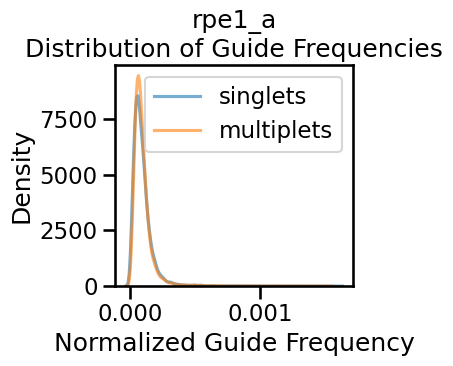

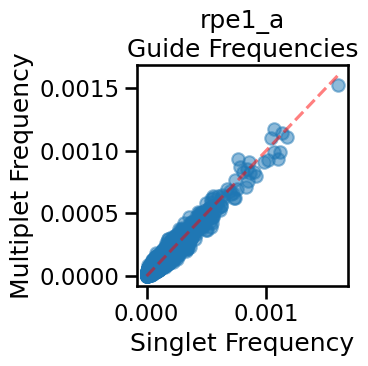

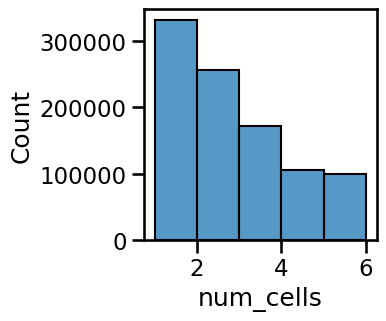


Correlation between singlets and multiplets: 0.955

Difference statistics for common guides:
count   10937.0000
mean       -0.0000
std         0.0000
min        -0.0002
25%        -0.0000
50%         0.0000
75%         0.0000
max         0.0002
Name: Difference, dtype: float64


In [16]:
rpe1_a = sc.read('/data/norman/southark/tfs_standardized/240118_RPE1_CRISPRa_scanpy_from_cellranger_aggr_singlets_and_multiplets_5umi_guide_thresh.h5ad')

rpe1_a = rpe1_a[rpe1_a.obs.num_cells <= 6].copy()


results_rpe1_a = analyze_guide_frequencies(rpe1_a, "rpe1_a", num_cell_col='num_cells', feature_col='thresholded_features')

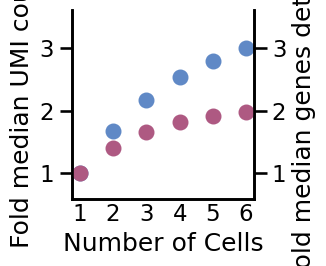

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate means if needed
mean_by_cells = rpe1_a.obs.groupby('num_cells')['UMI_count'].median()

#normalize by singlets
mean_by_cells = mean_by_cells/mean_by_cells[1]


# If your data is in sparse format, use:
n_genes_per_cell = rpe1_a.X.astype(bool).sum(axis=1).A1
rpe1_a.obs['n_genes'] = n_genes_per_cell

ngenes_by_cells =rpe1_a.obs.groupby('num_cells')['n_genes'].median()
#normalize by singlets
ngenes_by_cells = ngenes_by_cells/ngenes_by_cells[1]

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(3.6, 3))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot UMI counts on left axis
line1 = ax1.scatter(mean_by_cells.index, mean_by_cells.values, 
                    color='#6089C6',
                    s=100,
                    label='UMI Counts')

# Plot number of genes on right axis
line2 = ax2.scatter(ngenes_by_cells.index, ngenes_by_cells.values, 
                    color='#AE5982',
                    s=100,
                    label='Number of Genes')


# Set the same range for both axes
ax1.set_ylim(0.6, 3.6)
ax2.set_ylim(0.6, 3.6)


# Customize left axis
ax1.set_xlabel('Number of Cells')
ax1.set_ylabel('Fold median UMI count')
ax1.tick_params(axis='y')

# Customize right axis
ax2.set_ylabel('Fold median genes detected')
#ax2.tick_params(axis='y')

# Set x-axis ticks
ax1.set_xticks(mean_by_cells.index)
ax1.tick_params(axis='x', length=0)  # This removes the tick marks but keeps labels

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)


plt.tight_layout()

plt.savefig('rpe1_a_umi_count_saturation.pdf')
plt.show()